In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aiffel-ds-3-house-prices/sample_submission.csv
/kaggle/input/aiffel-ds-3-house-prices/train.csv
/kaggle/input/aiffel-ds-3-house-prices/test.csv


# 데이터 이해 및 탐색

## Import the library

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Load the dataset

In [3]:
# train data만 먼저 불러오기
house_df_org = pd.read_csv("/kaggle/input/aiffel-ds-3-house-prices/train.csv") # 원본 보존
house_df = house_df_org.copy()
# test = pd.read_csv("/kaggle/input/aiffel-ds-3-house-prices/test.csv.csv")
# submission = pd.read_csv("/kaggle/input/aiffel-ds-3-house-prices/sample_submission.csv.csv")

In [4]:
# 기본 정보 탐색(컬럼 확인)
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,968,20,RL,NaN,7390,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,135000
1,739,90,RL,60.0,10800,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2009,WD,Alloca,179000
2,696,20,RL,54.0,13811,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,176000


In [5]:
# 기본 정보 탐색(data type 및 null 값 확인)
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1168 non-null   int64  
 1   MSSubClass     1168 non-null   int64  
 2   MSZoning       1168 non-null   object 
 3   LotFrontage    950 non-null    float64
 4   LotArea        1168 non-null   int64  
 5   Street         1168 non-null   object 
 6   Alley          70 non-null     object 
 7   LotShape       1168 non-null   object 
 8   LandContour    1168 non-null   object 
 9   Utilities      1168 non-null   object 
 10  LotConfig      1168 non-null   object 
 11  LandSlope      1168 non-null   object 
 12  Neighborhood   1168 non-null   object 
 13  Condition1     1168 non-null   object 
 14  Condition2     1168 non-null   object 
 15  BldgType       1168 non-null   object 
 16  HouseStyle     1168 non-null   object 
 17  OverallQual    1168 non-null   int64  
 18  OverallC

- 생각보다 컬럼 수도 많고, 결측치 값의 column이 많음.
- 제거 가능한 컬럼 및 결측치를 채울 수 있는 값 탐색 필요.
- object type의 컬럼도 많음 - 추후 모델 적용을 위해 변환 가능한 타입 탐색 필요

In [6]:
print('데이터 세트의 Shape:', house_df.shape)
print('\n전체 feature 들의 type \n',house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nNull 컬럼과 그 건수:\n ', isnull_series[isnull_series > 0].sort_values(ascending=False)) # 결측치가 존재하는 열과 각 건수를 내림차순으로 출력 (결측치 1개이상 열 필터링)

데이터 세트의 Shape: (1168, 81)

전체 feature 들의 type 
 object     43
int64      35
float64     3
Name: count, dtype: int64

Null 컬럼과 그 건수:
  PoolQC          1162
MiscFeature     1120
Alley           1098
Fence            941
MasVnrType       694
FireplaceQu      545
LotFrontage      218
GarageType        69
GarageYrBlt       69
GarageFinish      69
GarageQual        69
GarageCond        69
BsmtFinType2      24
BsmtExposure      24
BsmtFinType1      23
BsmtCond          23
BsmtQual          23
MasVnrArea         8
Electrical         1
dtype: int64


## House Price Distribution

In [7]:
print(house_df['SalePrice'].describe())

count      1168.000000
mean     180194.401541
std       78869.201529
min       34900.000000
25%      129500.000000
50%      163995.000000
75%      213062.500000
max      755000.000000
Name: SalePrice, dtype: float64


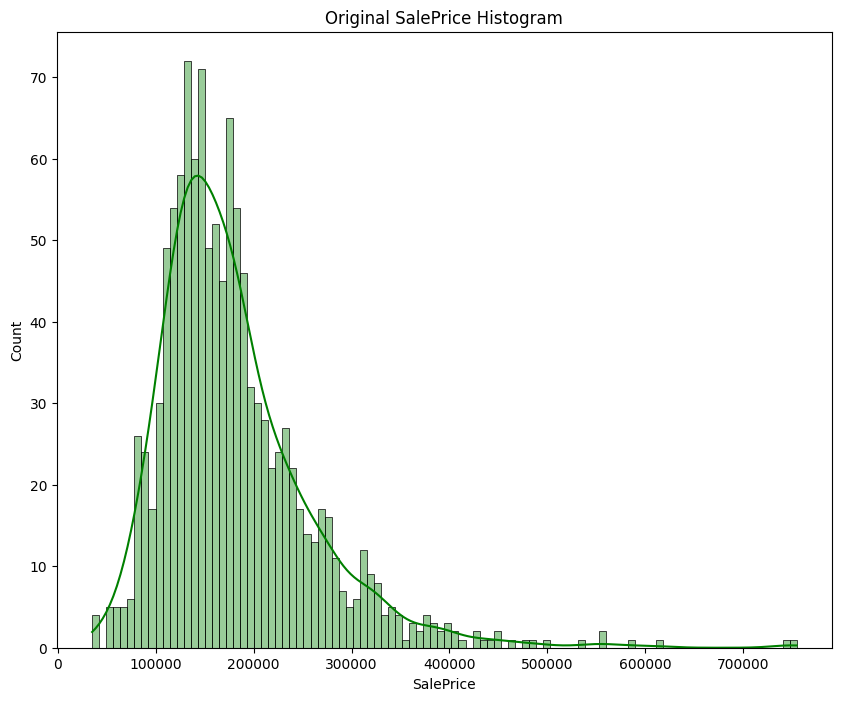

In [8]:
plt.figure(figsize=(10, 8))
plt.title('Original SalePrice Histogram')
sns.histplot(house_df['SalePrice'], color='g', bins=100, kde=True, alpha=0.4); #alpha 투명도

- 정규 분포가 아님, 왼쪽으로 치우쳐 있음
    - 고가 house가 일부 존재, 저가 house가 많음
    - 회귀 모델이 고가 주택에 과도하게 민감하게 반응 or 예측이 왜곡될 가능성 
- 회귀모델에 적용하기 위해 타깃 값의 분포도를 정규 분포 형태로 변환하기 위해 Log transformation 적용 
    - 회귀모델의 가정이 오차값(실제-예측값)이 정규분포를 따르고 
    - 독립변수와 종속변수 간에 linearity임을 가정하고 작동
    - Log transformation으로 정규분포에 가깝게 만들고자 함

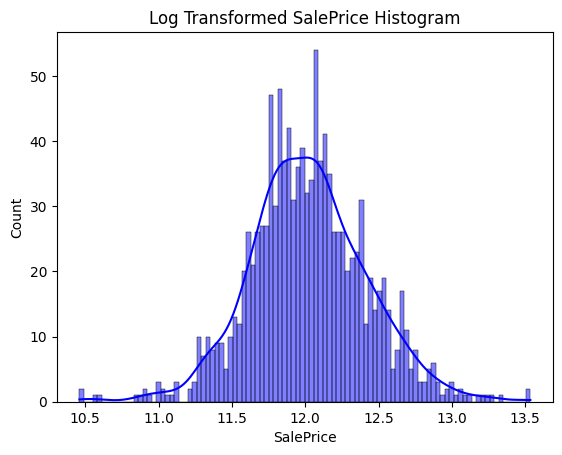

In [9]:
plt.title('Log Transformed SalePrice Histogram')
log_SalePrice = np.log1p(house_df['SalePrice']) # 값이 0일 때 발생할 수 있는 문제를 방지하기 위해 log1p사용
sns.histplot(log_SalePrice, color='b', bins=100, kde=True)
plt.show()

- 훨씬 정규분포에 가깝게 변환됨
- 예측시 다시 결과값을 expm1()으로 추후 환원필요

## Numerical data distribution

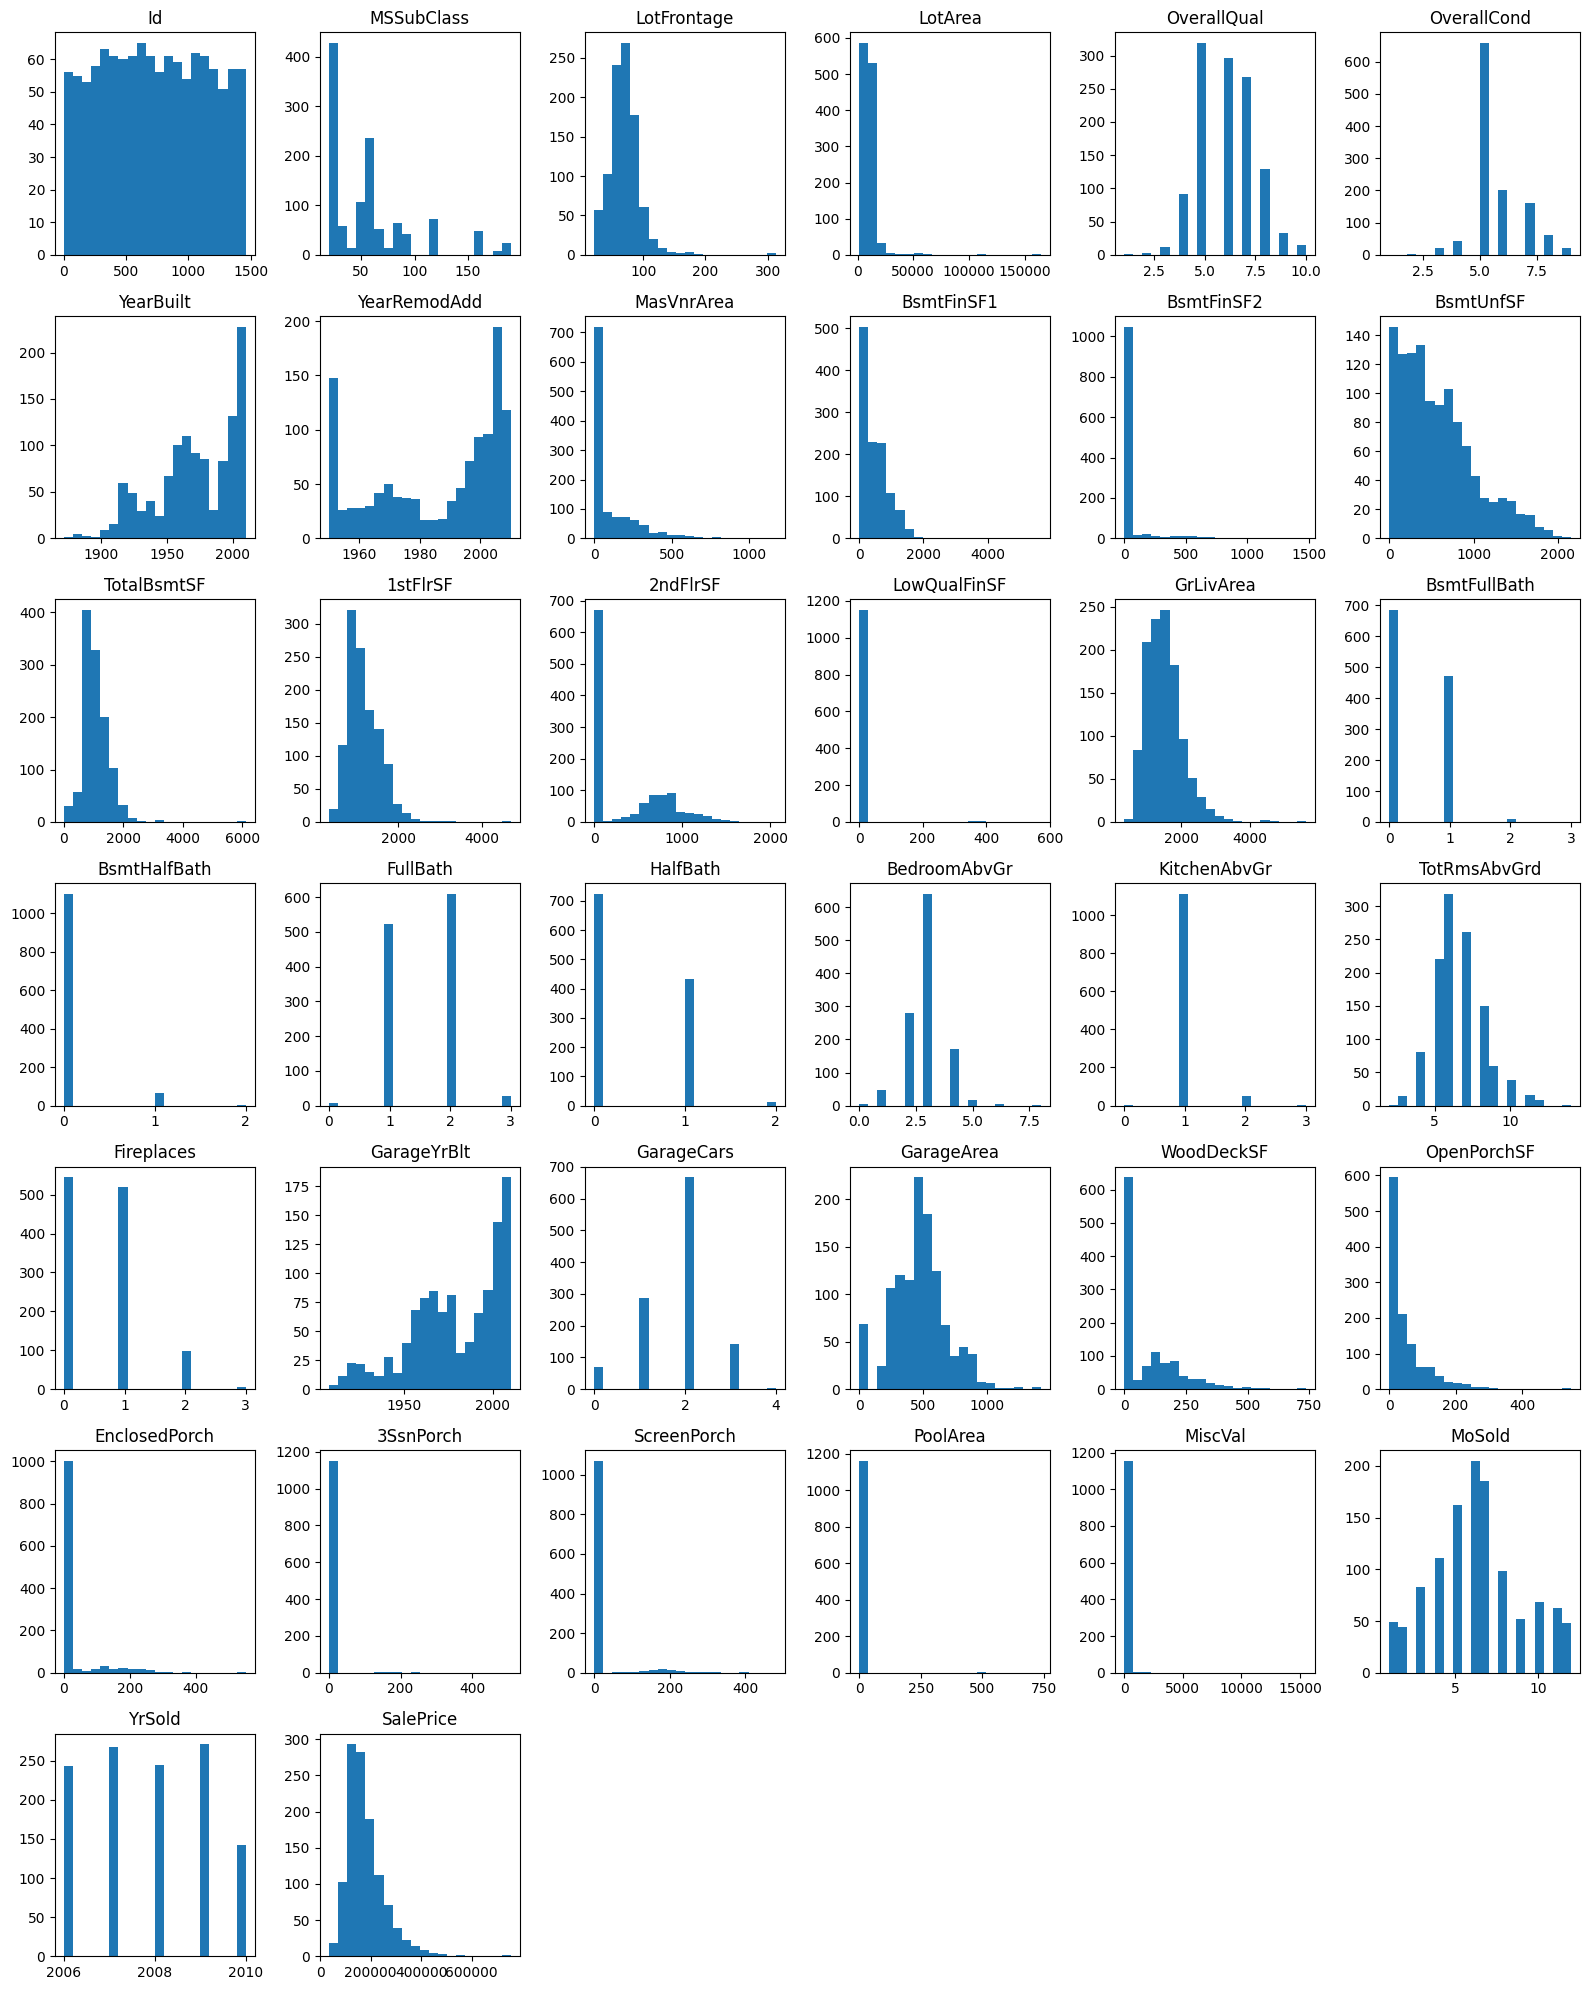

In [10]:
# 숫자형 데이터 추출
numeric_df = house_df.select_dtypes(include=['int64', 'float64'])
numeric_df.head()

# 숫자형 데이터 히스토그램
numeric_df.hist(figsize=(16, 20), bins=20, grid=False) # bins 20개 구간으로 나누어 데이터 막대 높이로 표기
plt.tight_layout() #그래프들 간의 간격을 자동으로 조정
plt.show()

- Null 비율이 높은 컬럼은 데이터 불균형이 확인 됨 (MasVnrAre, BsmtFinSF2, LowQualFinSF, EnclosedPorch, 3SnPorch, ScreenPorch, PoolArea, MiscVal) - isnull로 확인 후 컬럼 제거 예정
- SalePrice컬럼과 유사하게 왼쪽 치우치거나 반대로 오른쪽 치우친 데이터 확인됨 (LotArea, LotFrontage, YearBuilt, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, GrLivArea, GarageYrBlt) - 확인후 Log transformation
- YearBuilt, 

SalePrice와의 상관관계:
 SalePrice        1.000000
OverallQual      0.785111
GrLivArea        0.710178
GarageCars       0.632622
GarageArea       0.618311
1stFlrSF         0.597729
TotalBsmtSF      0.595882
FullBath         0.577860
TotRmsAbvGrd     0.548795
YearRemodAdd     0.504817
YearBuilt        0.501762
Fireplaces       0.475965
GarageYrBlt      0.472533
MasVnrArea       0.469261
BsmtFinSF1       0.379606
2ndFlrSF         0.333176
LotFrontage      0.321389
WoodDeckSF       0.308081
OpenPorchSF      0.294805
HalfBath         0.279331
LotArea          0.251558
BsmtFullBath     0.209688
BsmtUnfSF        0.197267
BedroomAbvGr     0.186202
ScreenPorch      0.133130
PoolArea         0.114399
MoSold           0.049252
3SsnPorch        0.028724
Id               0.003233
BsmtFinSF2      -0.005127
BsmtHalfBath    -0.005524
LowQualFinSF    -0.007937
YrSold          -0.018160
MiscVal         -0.021824
OverallCond     -0.059862
MSSubClass      -0.060677
EnclosedPorch   -0.110306
KitchenAbvGr    -0.

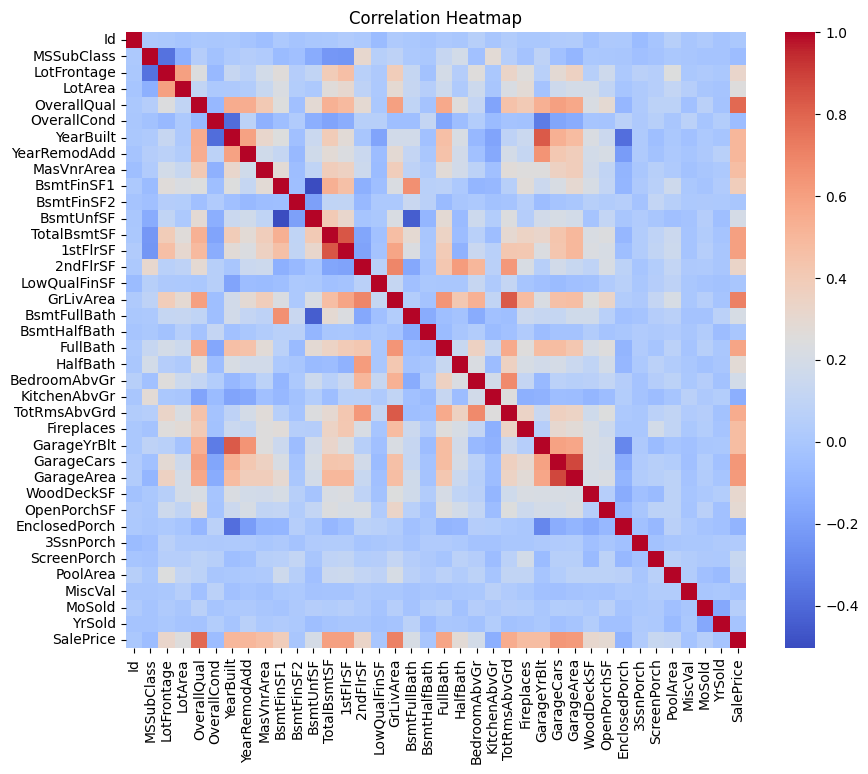

In [11]:
# 상관관계 heatmap으로 확인

correlation = numeric_df.corr()
numeric_corr = correlation['SalePrice'].sort_values(ascending=False)

print("SalePrice와의 상관관계:\n", numeric_corr)

# 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


<Axes: >

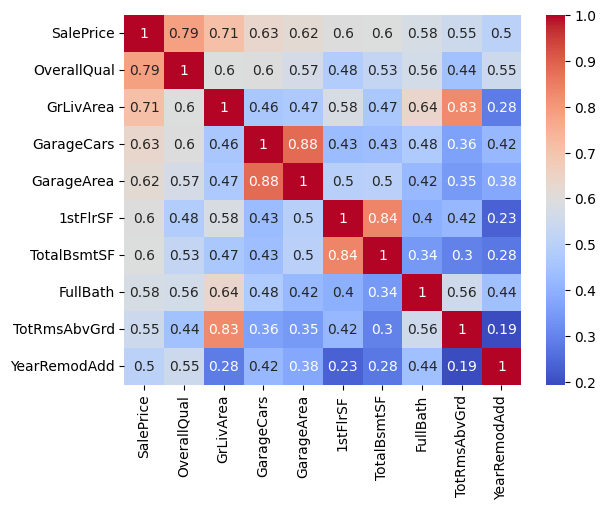

In [12]:
top_10_numeric_corr = numeric_corr.head(10)  # 상위 10개 선택

top_10_corr = correlation.loc[top_10_numeric_corr.index, top_10_numeric_corr.index] #.loc[row_labels, column_labels] 행(row)과 열(column)의 특정 라벨(이름)을 기반으로 데이터를 선택
sns.heatmap(top_10_corr, annot=True, cmap='coolwarm')


- 높은 상관관계
    - SalePrice와 상관관계 높은 변수: OverallQual 주택 품질 등급, GrLiveArea 지상 거주 면적 필수 유지
    - GarageCars(0.63) 및 GarageArea(0.62): 차고 크기와 수용 가능한 차량 수 - 하나만 선택하기
    - 1stFlrSF와 TotalBsmtSF(0.84): 1층 면적과 지하실 면적  - 합치기 TotalSF = 1stFlrSF + TotalBsmtSF + 2ndFlrsF(이것까지)
    - GrLivArea와 TotRmsAbvGrd(0.83): 거주 면적과 방 개수 - 하나만 선택
 
- 낮은 상관관계
    - MiscVal, PoolArea, LowQualFinSF, 3SsnPorch, ScreenPorch - 제거 고려
    - Id 고유식별자 제거

- 이외 통합 가능 변수
    - TotalBath = FullBath + 0.5 * HalfBath + BsmtFullBath + 0.5 * BsmtHalfBath
    

# 데이터 전처리

## Log Transformation
### SalePrice 는 Log Transformation 해서 적용

In [13]:
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

## Drop columns
### 불필요한 컬럼 제거

In [14]:
# Null 비율이 높은 컬럼 제거 - 모델 학습 기여도 낮을 가능성
# Null 비율 PoolQC (1162/1460 = 약 80%), MiscFeature (1120/1460 = 약 76%), Alley (1098/1460 = 약 75%), Fence (941/1460 = 약 64%) - 제거
# 낮은 상관관계 MiscVal, PoolArea, LowQualFinSF, 3SsnPorch, ScreenPorch - 제거 고려

for col in ['MiscVal', 'PoolArea', 'LowQualFinSF', '3SsnPorch', 'ScreenPorch']:
    print(house_df[col].value_counts()) # 특정 컬럼의 고유 값과 해당 값의 빈도를 쌍으로 반환

MiscVal
0        1122
400        10
500         6
700         5
600         4
2000        4
450         2
1200        2
480         2
1400        1
800         1
8300        1
54          1
3500        1
620         1
1150        1
560         1
15500       1
2500        1
350         1
Name: count, dtype: int64
PoolArea
0      1162
480       1
512       1
738       1
555       1
648       1
519       1
Name: count, dtype: int64
LowQualFinSF
0      1150
80        2
360       2
232       1
205       1
397       1
420       1
144       1
572       1
234       1
371       1
528       1
515       1
156       1
390       1
392       1
514       1
Name: count, dtype: int64
3SsnPorch
0      1150
144       2
508       1
168       1
140       1
23        1
153       1
196       1
216       1
245       1
238       1
407       1
320       1
130       1
290       1
96        1
180       1
162       1
Name: count, dtype: int64
ScreenPorch
0      1071
192       6
224       4
180       4
160       3


- 제거 고려했던 컬럼들의 값이 대부분 0이므로 모델에 기여도가 낮아 모델 단순화를 위해 제거 결정

In [15]:
# 불필요한 컬럼 제거
house_df = house_df.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MiscVal', 'PoolArea', 'LowQualFinSF', '3SsnPorch', 'ScreenPorch'])

In [16]:
# 고유식별자 id 컬럼 제거
house_df = house_df.drop(columns=['Id'])

## Refining and Consolidating Correlated Features
### 높은 상관관계 컬럼 및 통합 가능 컬럼 조정

In [17]:
# 1. GarageCars만 유지 (숫자가 더 단순 간단)
house_df = house_df.drop(columns=['GarageArea'])

# 2. TotalSF 생성 및 원래 컬럼 제거
house_df['TotalSF'] = house_df['1stFlrSF'] + house_df['TotalBsmtSF'] + house_df['2ndFlrSF']
house_df = house_df.drop(columns=['1stFlrSF', 'TotalBsmtSF', '2ndFlrSF'])

# 3. GrLivArea만 유지 (조금 더 Saleprice와 상관관계 높음)
house_df = house_df.drop(columns=['TotRmsAbvGrd'])

# 4. TotalBath 생성 및 원래 컬럼 제거
house_df['TotalBath'] = (house_df['FullBath'] +
                         0.5 * house_df['HalfBath'] +
                         house_df['BsmtFullBath'] +
                         0.5 * house_df['BsmtHalfBath'])
house_df = house_df.drop(columns=['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath'])


In [18]:
house_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSF,TotalBath
0,20,RL,NaN,7390,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,7,2008,WD,Normal,11.813037,2196,2.0
1,90,RL,60.0,10800,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,120,0,0,3,2009,WD,Alloca,12.095147,2400,6.0
2,20,RL,54.0,13811,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,125,0,0,7,2006,WD,Normal,12.078245,2249,3.0
3,20,RL,93.0,12030,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,168,228,0,12,2007,New,Partial,12.669810,3388,2.0
4,50,RL,60.0,8064,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,0,7,2007,WD,Normal,11.719134,1596,1.0


In [19]:
house_df.shape

(1168, 64)

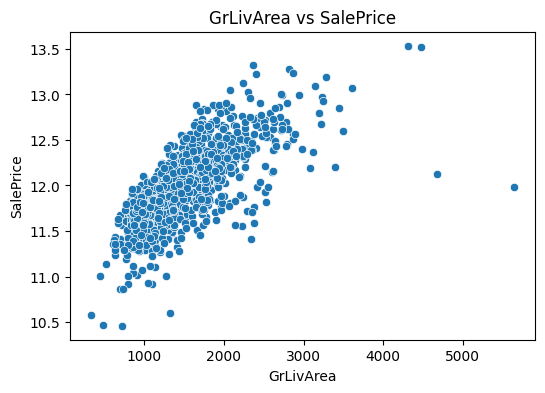

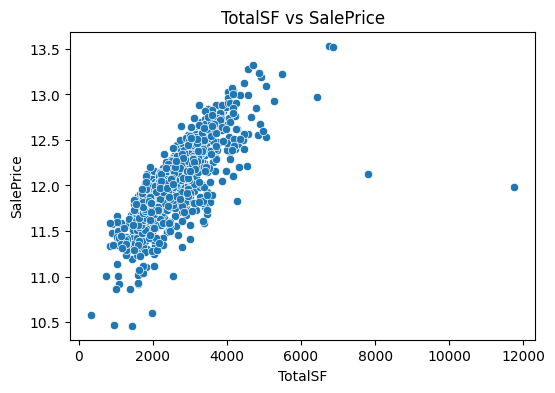

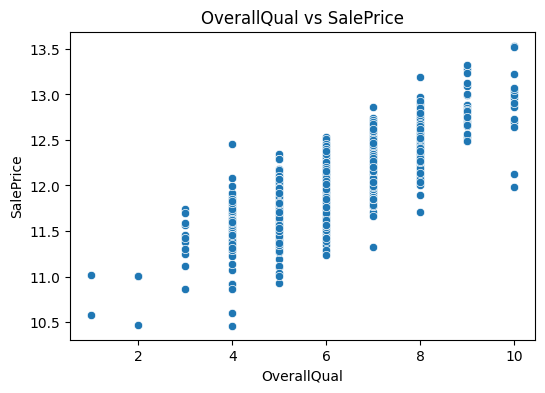

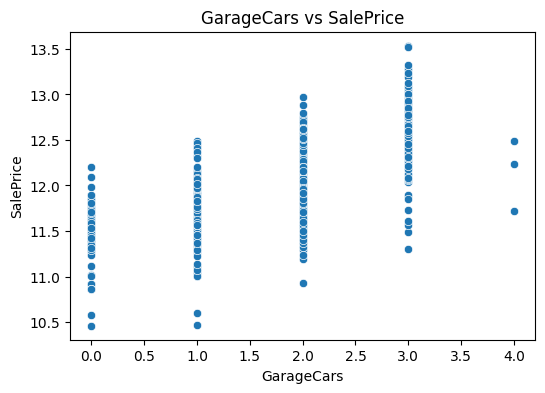

In [20]:
# 높은 상관관계를 보이는 변수들의 시각화로 선형모델에 적합한지 확인

import matplotlib.pyplot as plt
import seaborn as sns

# 주요 변수와 SalePrice 간 산점도
important_features = ['GrLivArea', 'TotalSF', 'OverallQual', 'GarageCars']

for feature in important_features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=house_df[feature], y=house_df['SalePrice'])
    plt.title(f'{feature} vs SalePrice')
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
    plt.show()

## Outlier filtering

- GrLivArea', 'TotalSF' 산점도를 보면 오른쪽에 두개가 이상치로 확인됨 - 면적이 넓은데 가격이 낮음
- 두개를 찾아서 제거

In [21]:
cond1 = house_df['GrLivArea']>4000
cond2 = house_df['SalePrice']<12.5
outlier_index = house_df[cond1 & cond2].index

print('이상치 레코드 index:', outlier_index.values)
print('이상치 삭제전 house_df.shape:', house_df.shape)

이상치 레코드 index: [ 64 373]
이상치 삭제전 house_df.shape: (1168, 64)


In [22]:
house_df.drop(outlier_index, axis=0, inplace=True)
print('이상치 삭제후 house_df.shape:', house_df.shape)

이상치 삭제후 house_df.shape: (1166, 64)


In [23]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1166 entries, 0 to 1167
Data columns (total 64 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1166 non-null   int64  
 1   MSZoning       1166 non-null   object 
 2   LotFrontage    948 non-null    float64
 3   LotArea        1166 non-null   int64  
 4   Street         1166 non-null   object 
 5   LotShape       1166 non-null   object 
 6   LandContour    1166 non-null   object 
 7   Utilities      1166 non-null   object 
 8   LotConfig      1166 non-null   object 
 9   LandSlope      1166 non-null   object 
 10  Neighborhood   1166 non-null   object 
 11  Condition1     1166 non-null   object 
 12  Condition2     1166 non-null   object 
 13  BldgType       1166 non-null   object 
 14  HouseStyle     1166 non-null   object 
 15  OverallQual    1166 non-null   int64  
 16  OverallCond    1166 non-null   int64  
 17  YearBuilt      1166 non-null   int64  
 18  YearRemodAdd 

## Missing Value
### 결측치 처리

In [24]:
# 결측치 처리: 제일 무난한 평균값으로 일단 대체, 추후 data 더 분석해 볼 시간이 있으면 최빈값이나 다른 값을 고려해 볼 예정
# 수치형 변수 선택
numeric_cols = house_df.select_dtypes(include=['float64', 'int64']).columns # 위에 추출해둔 것이 있으나 Id값이 포함되어 있어 다시 정의함
for col in numeric_cols:
    if house_df[col].isnull().sum() > 0:  # 결측치가 있는 컬럼만 처리
        house_df[col].fillna(house_df[col].mean(), inplace=True)

In [25]:
# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type :
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
FireplaceQu     object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


In [26]:
# 범주형 변수: 'None'으로 대체
categorical_cols = house_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if house_df[col].isnull().sum() > 0:
        house_df[col].fillna('None', inplace=True)

## DATA scaling and encoding
### 데이터 스케일링 및 인코딩

- 앞서 데이터 불균형을 보였던 컬럼들 확인
    - LotArea, GrLivArea: 우측편향 - log transformation
    - YearBuilt, GarageYrBlt: 특정 시기에 집중 - 일단 보류
    - BsmtUnfSF, TotalBsmtSF, 1stFlrSF: 편향된 분포 - log transformation
    - standardscaler 보다 편향된 데이터에 적합한 log transformation 선택, 추후 필요하면 ss도 추가 진행

In [27]:
log_transformed_cols = ['GrLivArea', 'LotArea', 'TotalSF', 'TotalBath']
for col in log_transformed_cols:
    house_df[col] = np.log1p(house_df[col])  # 로그 변환

- 문자열 데이터는 onehotencoding진행 - test set에도 잘 적용하기 위해 fit, transform 나누어 적용

In [28]:
house_df.select_dtypes(include=['object']).columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [29]:
from sklearn.preprocessing import OneHotEncoder

# One-Hot Encoding 적용할 컬럼 
categorical_cols = [
   'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
    'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
    'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
    'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
    'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
    'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'
]

# OneHotEncoder 생성
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)  # 새로운 값 무시, 배열 반환

# fit & transform
encoder.fit(house_df[categorical_cols])  
encoded_cols = encoder.transform(house_df[categorical_cols])  # 학습 데이터 변환

# 새로운 컬럼 이름 생성
encoded_col_names = encoder.get_feature_names_out(categorical_cols)

# 인코딩된 데이터를 데이터프레임으로 변환
encoded_df = pd.DataFrame(encoded_cols, columns=encoded_col_names, index=house_df.index)

# 원본 데이터에서 범주형 컬럼 삭제 후 인코딩된 컬럼 추가
house_df_ec = pd.concat([house_df.drop(columns=categorical_cols), encoded_df], axis=1)


# 학습 데이터 확인
house_df_ec.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,20,69.739451,8.908018,5,7,1955,1955,151.0,902,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,90,60.000000,9.287394,5,5,1987,1988,0.0,1200,0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,20,54.000000,9.533293,6,6,1987,1987,72.0,980,40,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,20,93.000000,9.395242,8,5,2007,2007,254.0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,50,60.000000,8.995289,5,7,1949,2006,0.0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


- 피처 엔지니어링으로 추가 파생변수 생성한 것 까지 포함하여 총120개 컬럼으로 새롭게 형성됨

# 모델 선택 및 비교

## Prepare the datasets

In [30]:
# from sklearn.model_selection import train_test_split

# def split_dataset(dataset, test_ratio=0.30):
#   test_indices = np.random.rand(len(dataset)) < test_ratio
#   return dataset[~test_indices], dataset[test_indices]

# train_ds_pd, valid_ds_pd = split_dataset(dataset_df)
# print("{} examples in training, {} examples in testing.".format(
#     len(train_ds_pd), len(valid_ds_pd)))

## Select the model 1

- get_rmse 함수를 생성하여 RMSE 값 반환
- get_rmses 함수를 생성하여 여러모델의 RMSE 값 반환

In [31]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test , pred)
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

def get_rmses(models):
    rmses = [ ]
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

1. 선형회귀모델
   - LinearRegression 기본 선형회귀모델: 간단하고 빠르게 예측, 과적합 위험이 적음 (먼저 빠르게 경향보기 좋음)
         - 상관관계(corr)에서 0.7 이상이면 강한 선형관계, 0.4~0.7은 중간 정도 선형관계로 볼 수 있는데, top_10_numeric_corr에서 중간 및 강한 선형관계를 보이는 변수들이 있어서 먼저 진행해보기 좋음.
   - Ridge: L2 정규화로 회귀계수크기를 제한하여 다중공선성(독립변수들간에 강한 상관관계) 문제를 완화, 과적합 방지하여 전체데이터에 대한 일반화 성능 개선 (현재 피처가 많아 서로 상관관계 높은 부분에서 안정적인 예측 가능할 모델)
   - Lasso: L1 정규화로 회귀계수 일부를 0으로 만들어 변수 줄임, 불필요한 피처를 제거하여 고차원 데이터셋에 적합(현재 피처가 많으므로 적합할 수 있음)

In [32]:
# #이상치 제거전 RMSE
# from sklearn.linear_model import LinearRegression, Ridge, Lasso
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error

# y_target = house_df_ec['SalePrice']
# X_features = house_df_ec.drop('SalePrice',axis=1, inplace=False)

# X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# # LinearRegression, Ridge, Lasso 학습, 예측, 평가
# lr_reg = LinearRegression()
# lr_reg.fit(X_train, y_train)

# ridge_reg = Ridge()
# ridge_reg.fit(X_train, y_train)

# lasso_reg = Lasso()
# lasso_reg.fit(X_train, y_train)

# models = [lr_reg, ridge_reg, lasso_reg]
# get_rmses(models)



In [33]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ec['SalePrice']
X_features = house_df_ec.drop('SalePrice',axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.119
Ridge 로그 변환된 RMSE: 0.112
Lasso 로그 변환된 RMSE: 0.243


[0.11853731648490819, 0.11228354136523012, 0.24327073368640773]

### 이상치 제거전 --> 후
- LinearRegression 로그 변환된 RMSE: 0.127 -> 0.119
- Ridge 로그 변환된 RMSE: 0.118 -> 0.112
- Lasso 로그 변환된 RMSE: 0.247 -> 0.243

    - 모든 모델에서 약간의 상승 있음을 확인확인

### 회귀계수 시각화

In [34]:
def get_top_bottom_coef(model, n=10):
    coef = pd.Series(model.coef_, index=X_features.columns)

    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low

In [35]:
def visualize_coefficient(models):
    fig, axs = plt.subplots(figsize = (24,10), nrows=1, ncols=3)
    fig.tight_layout()
    for i_num, model in enumerate(models):
        coef_high, coef_low = get_top_bottom_coef(model) # 상위 10개, 하위 10개 회귀계수 구하기
        coef_concat = pd.concat([coef_high, coef_low]) # concat으로 결합
        axs[i_num].set_title(model.__class__.__name__+'Coefficients')
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

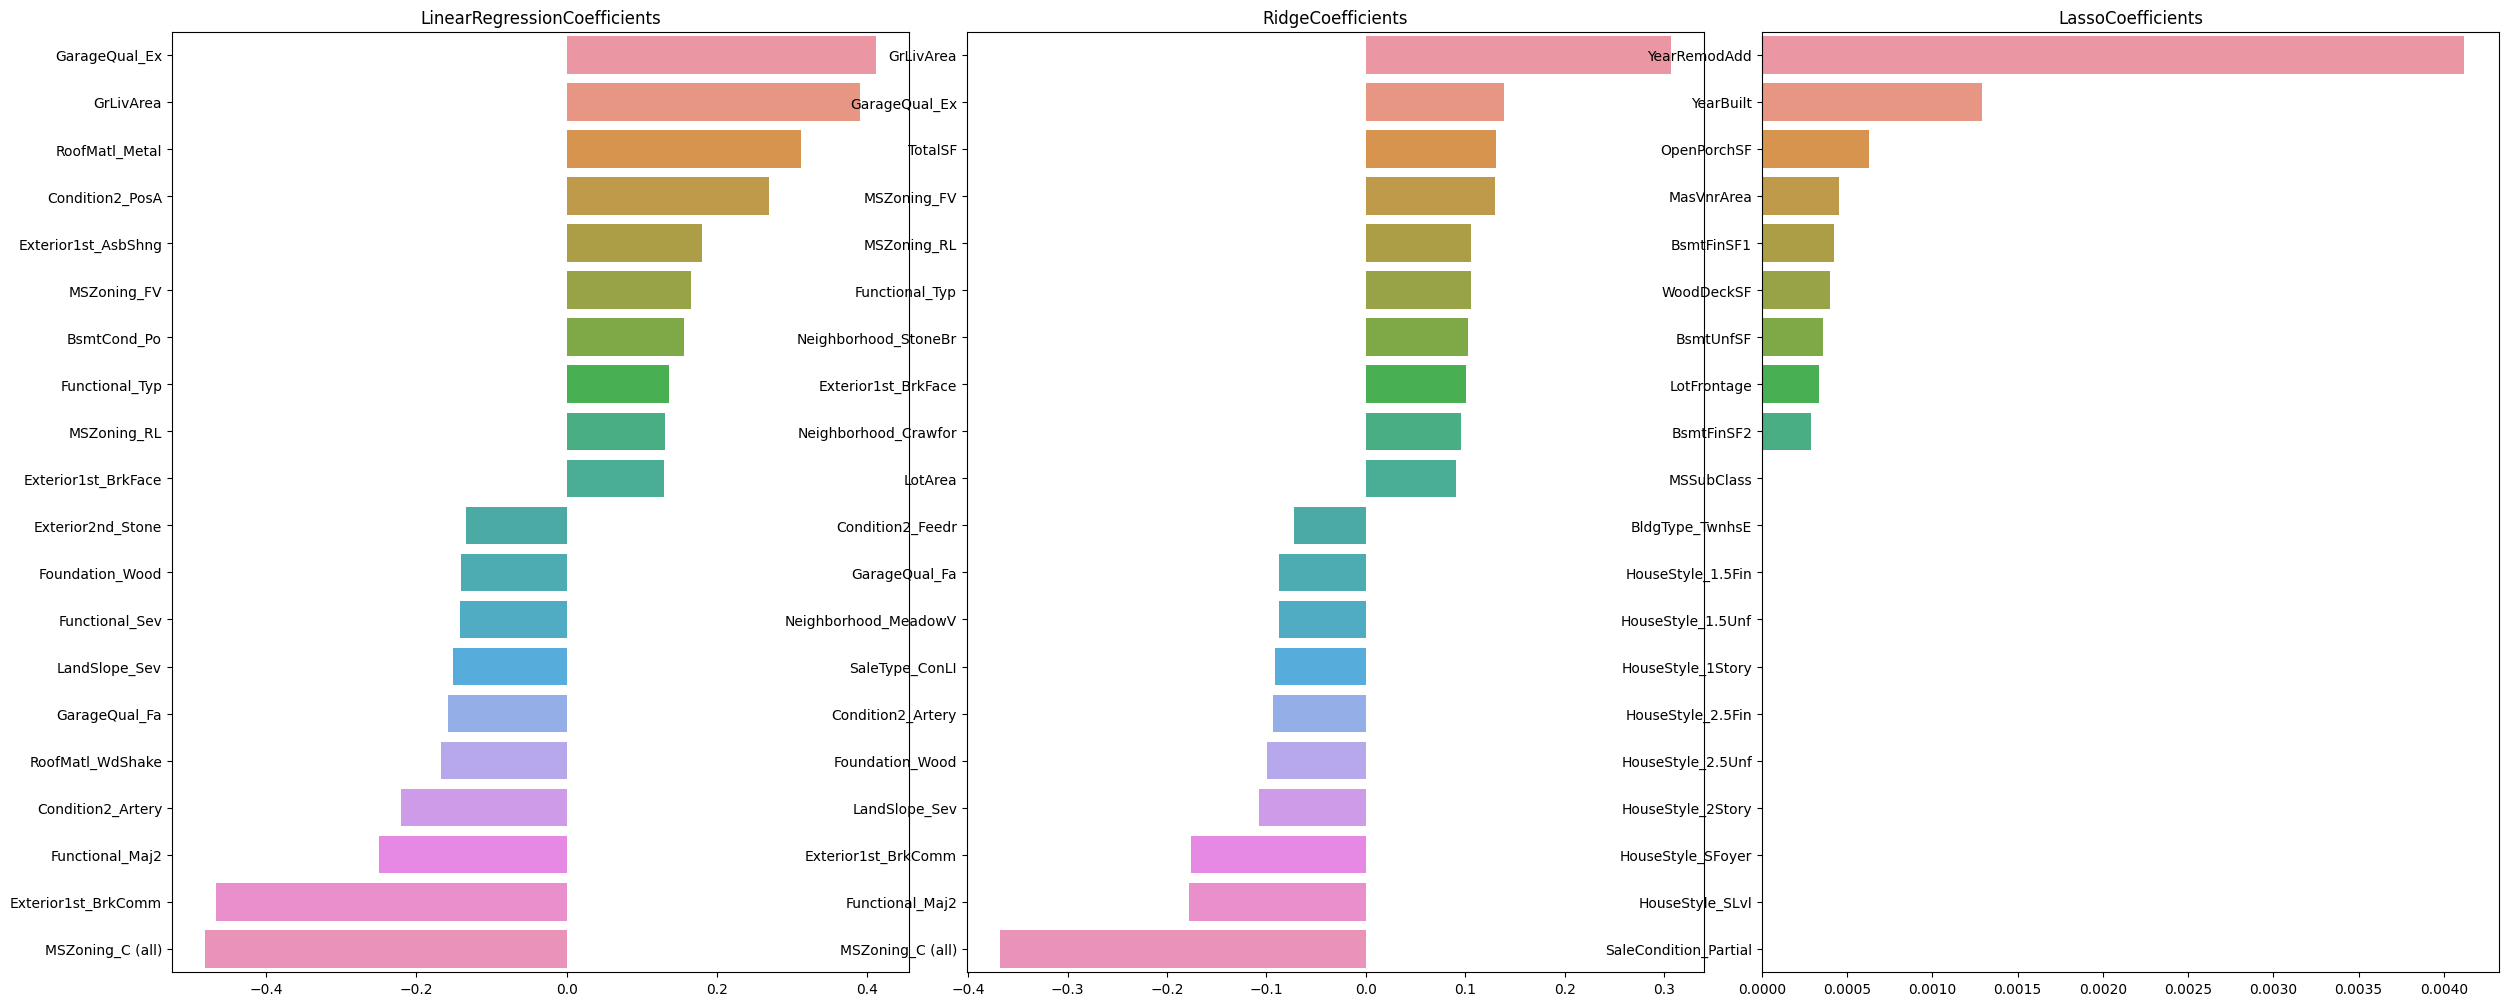

In [36]:
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

- Lasso 경우 회귀계수가 다른 모델과 다른 형태와 값을 가짐
- 하이퍼파라미터 튜닝 통해 최적값 도출 수행해보고자 함

In [37]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값:{1}, 최적 alpha:{2}'.format(model.__class__.__name__, np.round(rmse,4), grid_model.best_params_))

ridge_params = {'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1155, 최적 alpha:{'alpha': 5}
Lasso 5 CV 시 최적 평균 RMSE 값:0.1137, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.119
Ridge 로그 변환된 RMSE: 0.109
Lasso 로그 변환된 RMSE: 0.105


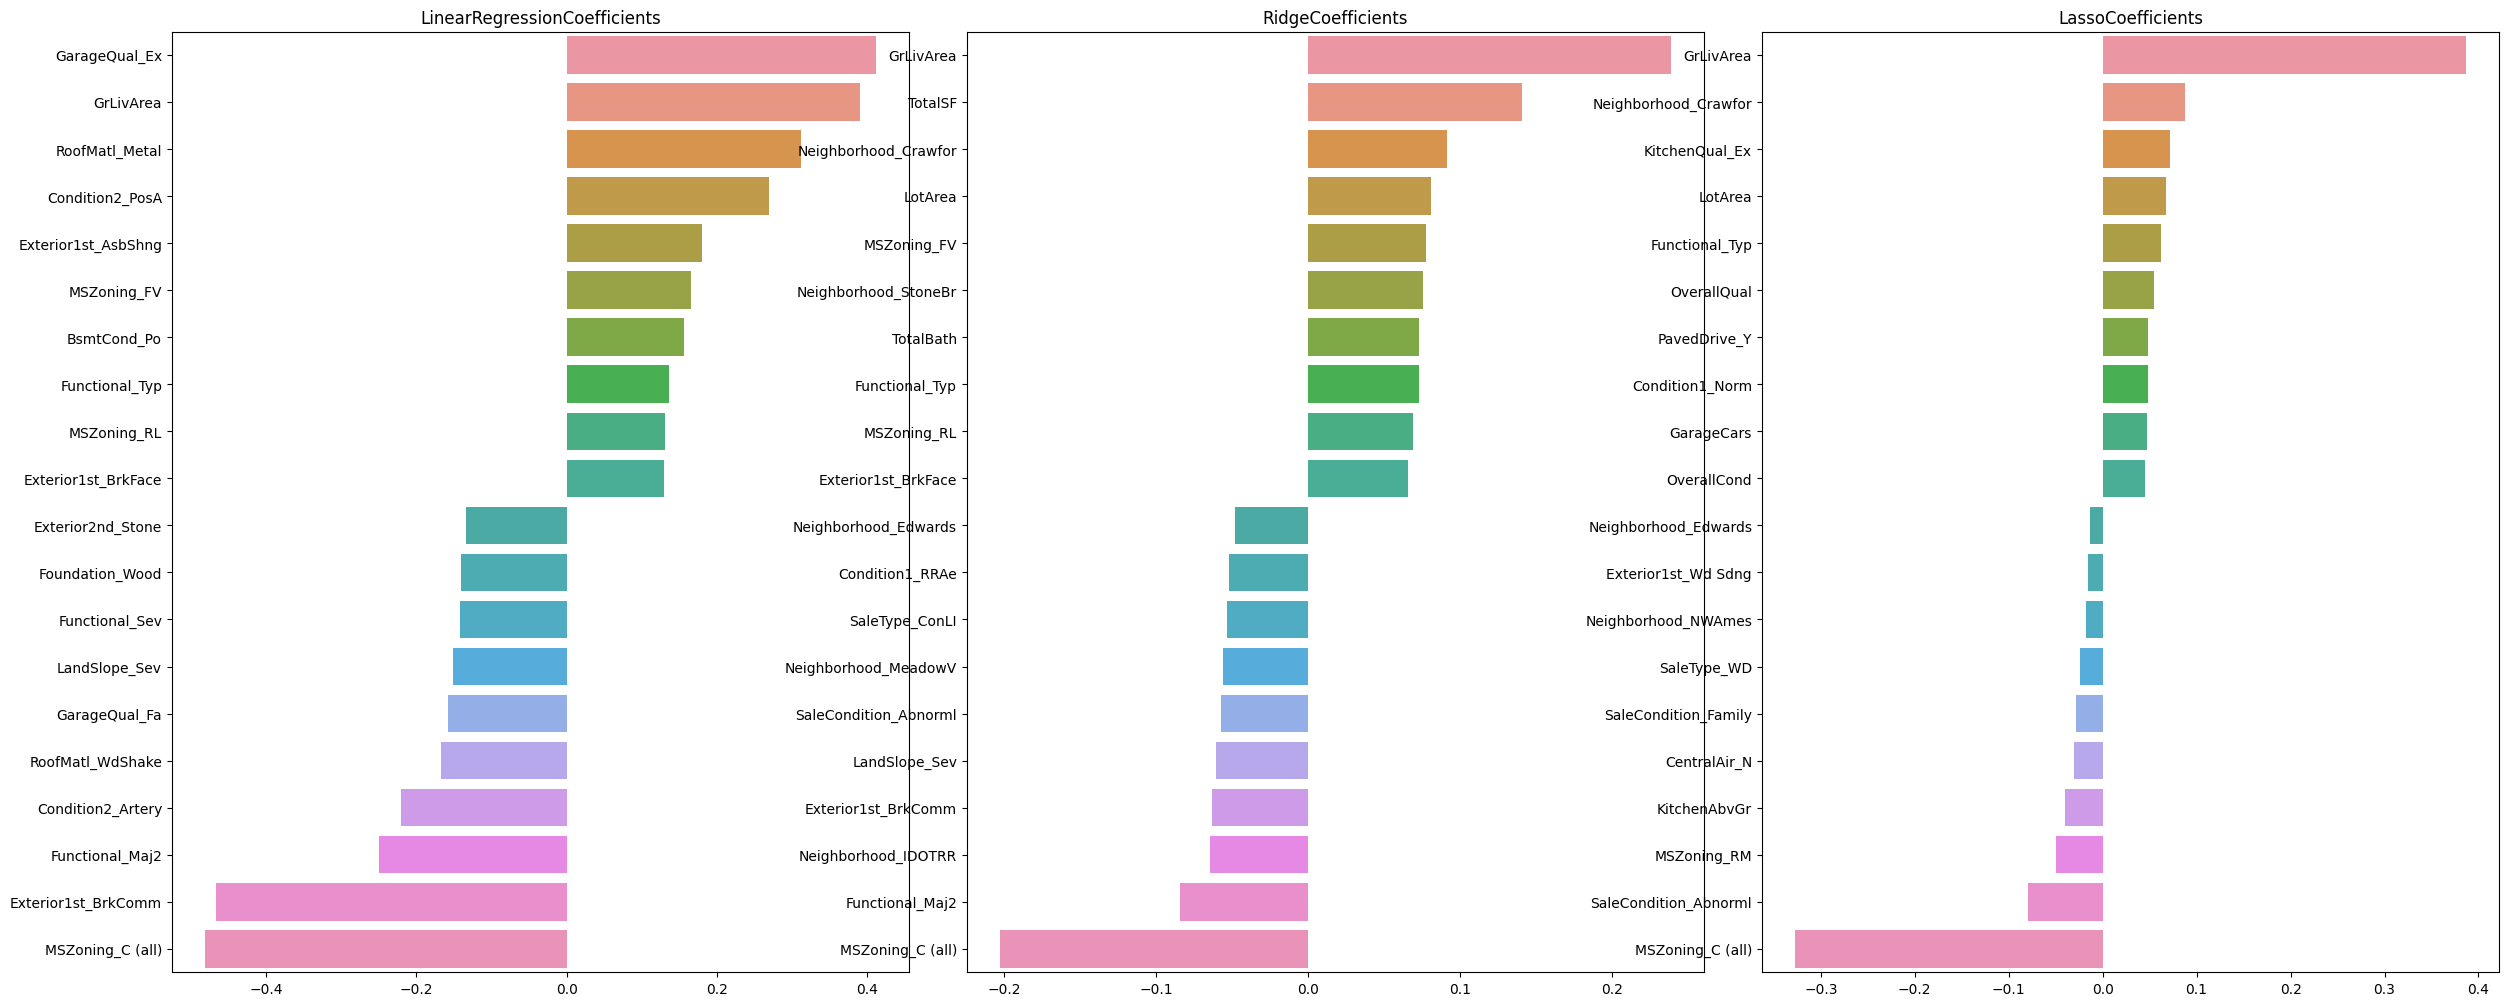

In [38]:
# 최적 값으로 학습 및 테스트 예측 및 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=5)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)
visualize_coefficient(models)

- 성능도 좋아지고 Lasso 경우도 다른 두 모델과 회귀계수 경향이 유사해짐

    -  LinearRegression 로그 변환된 RMSE: 0.119
    -  Ridge 로그 변환된 RMSE: 0.109
    -  Lasso 로그 변환된 RMSE: 0.105

- 혼합을 통한 예측

In [39]:
# 혼합 모델 및 개별 모델의 RMSE 값 출력 함수 생성
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test , pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE: {1}'.format(key, rmse))

In [40]:
# 개별 모델 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)
# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출 - Lasso가 조금 더 좋음으로 가중치를 조금 높임
pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}
#최종 혼합 모델, 개별모델의 RMSE 값 출력
get_rmse_pred(preds)


최종 혼합 모델의 RMSE: 0.1057148412440605
Ridge 모델의 RMSE: 0.10934700164913222
Lasso 모델의 RMSE: 0.10524062389581737


In [41]:
# 개별 모델 예측값 혼합으로 최종 예측값 도출 - Lasso가 조금 더 좋음으로 가중치를 조금 높임
pred = 0.6 * ridge_pred + 0.4 * lasso_pred
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}
#최종 혼합 모델, 개별모델의 RMSE 값 출력
get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.10654512297422071
Ridge 모델의 RMSE: 0.10934700164913222
Lasso 모델의 RMSE: 0.10524062389581737


In [42]:
# 개별 모델 예측값 혼합으로 최종 예측값 도출 - Lasso가 조금 더 좋음으로 가중치를 조금 높임
pred = 0.3 * ridge_pred + 0.7 * lasso_pred
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}
#최종 혼합 모델, 개별모델의 RMSE 값 출력
get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.10544697209504725
Ridge 모델의 RMSE: 0.10934700164913222
Lasso 모델의 RMSE: 0.10524062389581737


- 예상대로 Lasso에 조금 더 가중치를 주었을때 혼합모델의 RMSE가 소폭 향상됨을 알 수 있음.

## Select the model 2

2. 회귀 트리 모델
   - XGBoost: 비선형데이터 처리에 강점, 이상치와 결측치에 강함, 과적합 방지 및 피처 중요도 자동 선택, 하이퍼파라미터 튜닝 가능
   - LightGB: 조금 더 빠르게 예측 가능, 

In [43]:
# 하이퍼파라미터 설정 
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
best_xgb = print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값:0.1208, 최적 alpha:{'n_estimators': 1000}


In [44]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
best_lgbm = print_best_params(lgbm_reg, lgbm_params)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 166
[LightGBM] [Info] Start training from score 12.020420
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2263
[LightGBM] [Info] Number of data points in the train set: 933, number of used features: 157
[LightGBM] [Info] Start training from score 12.025656
[LightGBM] [Warning] Found w

In [45]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {'최종 혼합': pred,
         'XGBM': xgb_pred,
         'LGBM': lgbm_pred}
        
get_rmse_pred(preds)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2261
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 155
[LightGBM] [Info] Start training from score 12.029584
최종 혼합 모델의 RMSE: 0.11449513823634512
XGBM 모델의 RMSE: 0.11946202505237928
LGBM 모델의 RMSE: 0.11770764004634948


- 생각보다 높은 RMSE를 관찰함. 선형회귀모델이 더 적합해보임

## Select the Model 3

3. 스태킹 모델을 통한 회귀 예측

In [46]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [47]:
# get_stacking_base_datasets( )은 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환. 
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반(Base)모델이 생성한 학습용/테스트용 데이터 반환. 
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)  
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
LGBMRegressor  model 시작 
	 폴드 세트:  0  시작 
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2078
[LightGBM] [Info] Number of data points in the train set: 745, number of used features: 146
[LightGBM] [Info] Start training from score 12.030249
	 폴드 세트:  1  시작 
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=tru

In [48]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 Stacking 형태로 결합.  
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, 
                                      xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, 
                                     xgb_test, lgbm_test), axis=1)

# 최종 메타 모델은 라쏘 모델을 적용. 
meta_model_lasso = Lasso(alpha=0.001)

#기반 모델의 예측값을 기반으로 새롭게 만들어진 학습 및 테스트용 데이터로 예측하고 RMSE 측정.
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test , final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)



스태킹 회귀 모델의 최종 RMSE 값은: 0.10453376244331261


- Ridge & Lasso 최종 혼합 모델의 RMSE: 0.10544697209504725- 
Ridge 모델의 RMSE: 0.1093470016491322
- 
Lasso 모델의 RMSE: 0.105240623895817
- 스태킹 회귀 모델의 최종 RMSE 값은: 0.10453376244331261--> 스태킹 회귀모델로 최종 Test 예측
37

# 테스트 예측

## Load the Test data 

In [50]:
test_df_org = pd.read_csv("/kaggle/input/aiffel-ds-3-house-prices/test.csv")

In [51]:
test_df = test_df_org.copy()

In [52]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,86,60,RL,121.0,16059,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Normal
1,227,60,RL,82.0,9950,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2007,WD,Abnorml
2,492,50,RL,79.0,9490,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,8,2006,WD,Normal
3,64,70,RM,50.0,10300,Pave,NaN,IR1,Bnk,AllPub,...,0,0,NaN,GdPrv,NaN,0,4,2010,WD,Normal
4,576,50,RL,80.0,8480,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,10,2008,COD,Abnorml


## Test data를 동일하게 전처리

In [52]:
test_df = test_df.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MiscVal', 'PoolArea', 'LowQualFinSF', '3SsnPorch', 'ScreenPorch', 'Id'])

In [53]:
# 1. GarageCars만 유지
test_df = test_df.drop(columns=['GarageArea'])

# 2. TotalSF 생성 및 원래 컬럼 제거
test_df['TotalSF'] = test_df['1stFlrSF'] + test_df['TotalBsmtSF'] + test_df['2ndFlrSF']
test_df = test_df.drop(columns=['1stFlrSF', 'TotalBsmtSF', '2ndFlrSF'])

# 3. GrLivArea만 유지 
test_df = test_df.drop(columns=['TotRmsAbvGrd'])

# 4. TotalBath 생성 및 원래 컬럼 제거
test_df['TotalBath'] = (test_df['FullBath'] +
                         0.5 * test_df['HalfBath'] +
                         test_df['BsmtFullBath'] +
                         0.5 * test_df['BsmtHalfBath'])
test_df = test_df.drop(columns=['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath'])


In [54]:
# 결측치 처리: 제일 무난한 평균값으로 일단 대체
# 수치형 변수 선택
numeric_cols = test_df.select_dtypes(include=['float64', 'int64']).columns # 위에 추출해둔 것이 있으나 Id값이 포함되어 있어 다시 정의함
for col in numeric_cols:
    if test_df[col].isnull().sum() > 0:  # 결측치가 있는 컬럼만 처리
        test_df[col].fillna(test_df[col].mean(), inplace=True)
        
        
# Null 값이 있는 피처명과 타입을 추출
null_column_count = test_df.isnull().sum()[test_df.isnull().sum() > 0]

# 범주형 변수: 'None'으로 대체
categorical_cols = test_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if test_df[col].isnull().sum() > 0:
        test_df[col].fillna('None', inplace=True)

In [55]:
log_transformed_cols = ['GrLivArea', 'LotArea', 'TotalSF', 'TotalBath']
for col in log_transformed_cols:
    test_df[col] = np.log1p(test_df[col])  # 로그 변환

In [56]:
# 테스트 데이터에 동일한 규칙 적용
test_encoded = encoder.transform(test_df[categorical_cols])

# 테스트 데이터 인코딩 결과를 데이터프레임으로 변환
test_encoded_df = pd.DataFrame(test_encoded, columns=encoded_col_names, index=test_df.index)

# 테스트 데이터에 범주형 컬럼 제거 후 인코딩된 컬럼 추가
test_df_ec = pd.concat([test_df.drop(columns=categorical_cols), test_encoded_df], axis=1)

# 테스트 데이터에서 fit()을 사용하지 않음
test_df_ec.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,121.0,9.684087,8,5,1991,1992,284.0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,60,82.0,9.205428,7,5,1995,1995,290.0,565,0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,50,79.0,9.158099,6,7,1941,1950,0.0,403,165,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,70,50.0,9.239996,7,6,1921,1950,0.0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,50,80.0,9.045584,5,5,1947,1950,0.0,442,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [57]:
# 넘파이 배열로 변환
test_df_n = test_df_ec.values

# 전체 데이터 결합
X_all = np.concatenate((X_train, X_test), axis=0)  # 전체 입력 데이터
y_all = np.concatenate((y_train, y_test), axis=0)  # 전체 타겟 데이터

In [58]:
# test_df 예측값 생성
ridge_test_final = get_stacking_base_datasets(ridge_reg, X_all, y_all, test_df_n, 5)[1]
lasso_test_final = get_stacking_base_datasets(lasso_reg, X_all, y_all, test_df_n, 5)[1]
xgb_test_final = get_stacking_base_datasets(xgb_reg, X_all, y_all, test_df_n, 5)[1]
lgbm_test_final = get_stacking_base_datasets(lgbm_reg, X_all, y_all, test_df_n, 5)[1]

# Stacking 데이터 생성
Stack_final_Test = np.concatenate((ridge_test_final, lasso_test_final, 
                                   xgb_test_final, lgbm_test_final), axis=1)

# 메타 모델로 최종 예측
final_predictions = meta_model_lasso.predict(Stack_final_Test)

# 로그 변환된 SalePrice를 역변환 (로그 변환된 경우)
final_predictions_exp = np.expm1(final_predictions)
final_predictions_exp

Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
LGBMRegressor  model 시작 
	 폴드 세트:  0  시작 
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2273
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 165
[LightGBM] [Info] Start training from score 12.014044
	 폴드 세트:  1  시작 
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2274
[LightGBM] [Info] Number of data points in the train set: 933, number of used features: 15

array([267102.55009119, 261107.60747022, 150059.42403265, 136853.1302988 ,
       111712.73616489, 290646.70948425, 234327.67449126,  84639.56264661,
       174970.56760383, 132215.82207868, 303816.402143  , 222158.8031209 ,
        72219.34575151,  81250.75679514, 137685.60763448, 139397.33621906,
       132640.29398963, 269751.29947593, 219264.26345868, 116348.83920359,
       253309.8100204 , 143992.43602642, 139486.65456124, 225172.75367827,
       124284.39568161, 195121.1587894 , 134299.13657845, 146445.24656457,
       346318.9074943 , 193516.40563433, 194909.11618591, 195719.84805842,
       164795.4156181 , 155906.58014052, 171612.2969414 , 357380.4188625 ,
       103604.62723953, 208909.33632186, 247075.71370826, 133988.69266731,
       303174.00537424, 211168.94410379, 118520.30162935, 323988.68160197,
       126243.11772579, 164420.77626404, 120194.83754059, 134276.7247965 ,
       209853.74994184, 168737.91725142, 193585.65782528, 134125.63739531,
       210702.32211426, 1

In [59]:
# submission = pd.read_csv("/kaggle/input/aiffel-ds-3-house-prices/sample_submission.csv")
submission = pd.DataFrame({
    'Id': test_df.index,  # Test_df의 Id 값
    'SalePrice': final_predictions_exp
})
submission.to_csv('submission.csv', index=False)
print("최종 제출 파일이 저장되었습니다!")


최종 제출 파일이 저장되었습니다!


In [60]:
submission_loaded = pd.read_csv('submission.csv')
submission_loaded

,Id,SalePrice
0,0,267102.550091
1,1,261107.607470
2,2,150059.424033
3,3,136853.130299
4,4,111712.736165
...,...,...
287,287,223769.864970
288,288,184150.830519
289,289,168657.669091
290,290,134164.350150
